# Extracting informations from Text using Text Mining Techniques

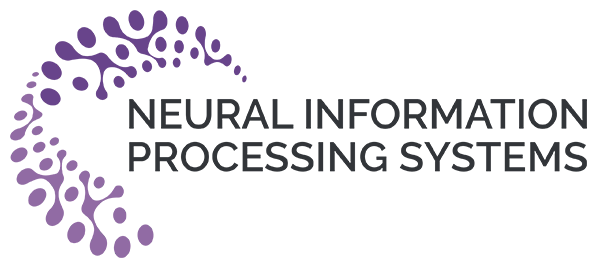

**Neural Information Processing System (NIPS) is one of the top machine learning conferences in the world. It covers topics ranging from deep learning and computer vision to cognitive science and reinforcement learning.** My intention is to extract as much information as possible from this data, and try all the text mining techniques on this dataset.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nips-papers/paper_authors.csv
/kaggle/input/nips-papers/papers.csv
/kaggle/input/nips-papers/authors.csv
/kaggle/input/nips-papers/database.sqlite


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud
import spacy
nlp = spacy.load('en_core_web_sm')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Here we will work with only papers file.

In [3]:
data = pd.read_csv("/kaggle/input/nips-papers/papers.csv")
data.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [4]:
print(data.columns)
print(len(data.columns))

Index(['id', 'year', 'title', 'event_type', 'pdf_name', 'abstract',
       'paper_text'],
      dtype='object')
7


In [5]:
data.shape

(7241, 7)

In [6]:
data.isnull().sum()

id               0
year             0
title            0
event_type    4819
pdf_name         0
abstract         0
paper_text       0
dtype: int64

So the above chart represents that in our dataset most papers got released for the year 2017. Now let's look at the text a little.

Hmmm... So our text size is quite big. Let's find out word-size for the texts using histogram. Let's just roughly get an idea before cleaning the text.

In [7]:
data['Number_of_words'] = data['paper_text'].apply(lambda x:len(str(x).split()))

In [8]:
data.drop(data[data["Number_of_words"]<200].index, inplace = True)

So using the above code I have removed all the texts which are less than 200 words, basically there were only 3 rows, which contains data of this small size.

Now we will try to see how many documents have words count between 200 and 500.

# Text Cleaning

Now let's start the text cleaning process.

In [9]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
data["cleaned_paper_text"]=data["paper_text"].apply(cleaned_text)

In [10]:
data["cleaned_paper_text"] = data["cleaned_paper_text"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

Now let's try to create a wordcloud from this cleaned text.

Now we will do the next step cleaning process which is stop word removal and then we will lemmatize the words.

In [11]:
stop=stopwords.words('english')
stop.append("also")
data["stop_removed_paper_text"]=data["cleaned_paper_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [12]:
data["tokenized"]=data["stop_removed_paper_text"].apply(lambda x: nltk.word_tokenize(x))

In [13]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
data["lemmatized"]=data["tokenized"].apply(lambda x: word_lemmatizer(x))
data["lemmatize_joined"]=data["lemmatized"].apply(lambda x: ' '.join(x))

Now let's see how the word distribution has changed using a histogram after doing some text cleaning.

In [14]:
data['Number_of_words_for_cleaned'] = data['lemmatize_joined'].apply(lambda x:len(str(x).split()))

So we can clearly see the shift after stopword removal. Now let's see the top 30 most frequent words in our whole text. Also let's remove documents with word size more than 6000, cause we don't want to deal with at the moment a document of this size.

In [15]:
data.drop(data[data["Number_of_words_for_cleaned"]>4500].index, inplace = True)

So in the above we can see that there are still some stopwords present, but I want to keep them, as they are adding some meaning to our text. Now let's do vectorization, using 

# Vectorization using Word2vec

Before begining, word2vec takes list of words as an input to train the neural network model. Word2vec is a neural network with 1 hidden layer. Input layer takes the vocabulary of words, and hidden layer's size is the vector size of the word that we want, so here we will be giving 250 as the hidden layer size or we want size of the vectors for each word to be 250.

In [16]:
tokens = data["lemmatize_joined"].apply(lambda x: nltk.word_tokenize(x))

So what's happening below is we are giving the list of words, and we are limiting some words, meaning, we are allowing those words in our vocabulary in the model, whose frequency is more than 600 using **min_count**, as we want a little cleaner t-sne plot, otherwise the plot will be a huge mess, as their are too much words in our data, so to make it a little cleaner, I just limited it to the words which has a frequency of above 600, also the vector size of a word here will be 250 and we defined it using **size**, and for **window** 10 mean, for a word, it will look 10 words right to it and 10 words to it's left. **Alpha** and **min_alpha** are the learning rates, so we will start with the learning rate of 0.03, and later near optimization, the learning rate will lower down to 0.0007, to find the optimized weights.

In [17]:
w2v_model = Word2Vec(tokens,
                     min_count=600,
                     window=10,
                     size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

Now let's see the vector representation of the word "model".

In [18]:
v1 = w2v_model.wv['model']
print(v1)

[ 1.33340764e+00  6.41618311e-01  1.12289257e-01  2.62987733e-01
  7.05129862e-01  5.29106736e-01  4.80656140e-02 -9.28226858e-02
  1.28290999e+00 -1.90934825e+00  5.61086118e-01  1.03680015e+00
  1.44986236e+00  2.61674404e-01 -1.64878845e+00  1.53450623e-01
 -9.70068276e-01  8.60970318e-01 -1.21405661e+00  2.16127729e+00
 -2.11196709e+00  1.36762929e+00 -8.05917323e-01  1.20056868e+00
 -7.05798507e-01 -1.23609826e-01  2.00172484e-01 -7.33336747e-01
  1.38648427e+00 -1.83533692e+00 -2.20501089e+00  4.55603242e-01
  3.96994859e-01  8.32958937e-01  4.06831950e-01 -7.60245860e-01
 -1.81176722e-01  9.55311805e-02 -1.09981859e+00 -1.09188437e+00
  1.59208035e+00 -1.99353266e+00 -1.04054213e+00 -1.35612047e+00
  7.08828628e-01 -7.18155980e-01 -3.75724107e-01  4.64305937e-01
 -2.72855341e-01  2.24503040e-01  1.22496510e+00 -9.07063723e-01
 -1.85491300e+00  7.44083464e-01 -5.20232260e-01 -1.29495108e+00
  4.34153795e-01  1.30993044e+00 -2.73754776e-01 -4.27440286e-01
  1.63602149e+00  5.77829

So it's a vector of 250 numbers, as described by us while creating the model, and each dimension represents some aspect of the word. Now let's see some similar words.

# Similar words using Word2vec

In [19]:
sim_words = w2v_model.wv.most_similar('estimator')
print(sim_words)

[('estimators', 0.7590619921684265), ('estimate', 0.5608056783676147), ('unbiased', 0.526831865310669), ('estimation', 0.4711422622203827), ('asymptotically', 0.46751293540000916), ('plug', 0.46358200907707214), ('asymptotic', 0.406060129404068), ('variance', 0.3832724988460541), ('statistic', 0.3788277804851532), ('density', 0.35760432481765747)]


In [20]:
sim_words_2 = w2v_model.wv.most_similar('synapse')
print(sim_words_2)

[('synapses', 0.7024596333503723), ('currents', 0.6252284646034241), ('synaptic', 0.6148661971092224), ('neuron', 0.5973620414733887), ('presynaptic', 0.5808377265930176), ('voltage', 0.5631074905395508), ('postsynaptic', 0.5472843647003174), ('circuit', 0.5338786840438843), ('device', 0.5102781653404236), ('conductance', 0.5087881684303284)]


In [21]:
sim_words_3 = w2v_model.wv.most_similar('connectivity')
print(sim_words_3)

[('connections', 0.5089238882064819), ('activity', 0.4535295367240906), ('brain', 0.44288042187690735), ('topology', 0.43096330761909485), ('adjacency', 0.426198810338974), ('fmri', 0.4242168664932251), ('connection', 0.4086190462112427), ('voxels', 0.4008938670158386), ('strengths', 0.395915687084198), ('cortical', 0.3910428583621979)]


# TSNE Plot for 2 models

About T-SNE, it is mainly used for showing high dimensional figure to a lower dimensional figure. So here, as we know the words has a dimension of 250, and we are showing it in 2-D figure, just imagine! This is the job of T-SNE. So the concept says, similar words will have similar vectors, and so those similar words will be closer in the vector space, or sometimes may even overlap, if they are too similar.

In [22]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


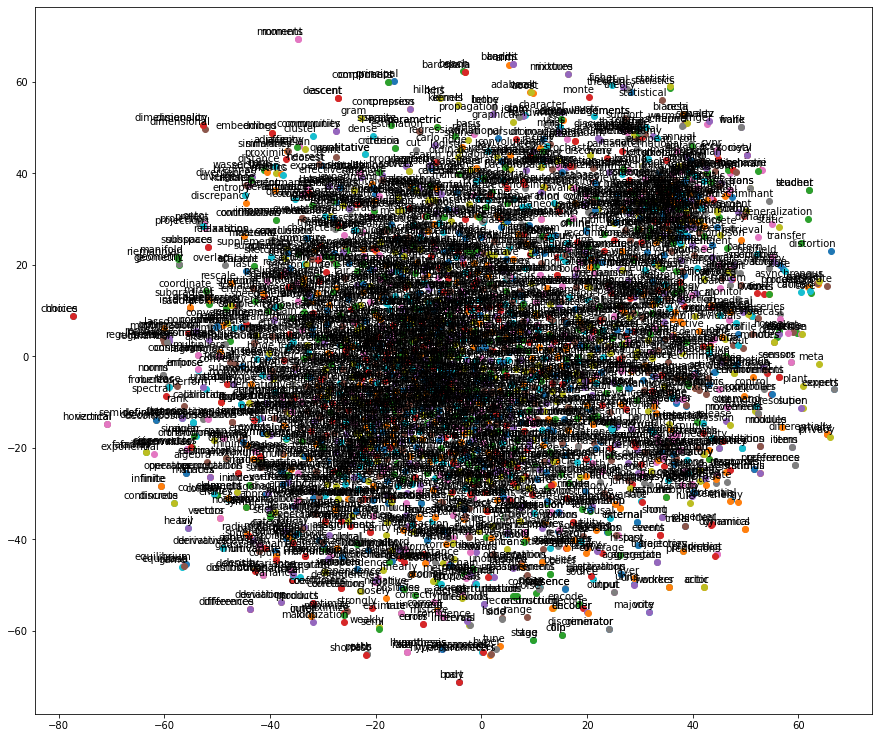

In [23]:
tsne_plot(w2v_model)

Now let's create another model, and this time we will be using words with frequency more than 2000 and plot it using T-SNE, so that our plot looks a little more cleaner. But I believe this shouldn't be done, as words which are repeating 1000 times or more in the corpus, must have some importance, I am doing this just to show the plot a little cleaner, it is not recommended at all.

In [24]:
w2v_model_2 = Word2Vec(tokens,
                     min_count=1000,
                     window=10,
                     size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed=50)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


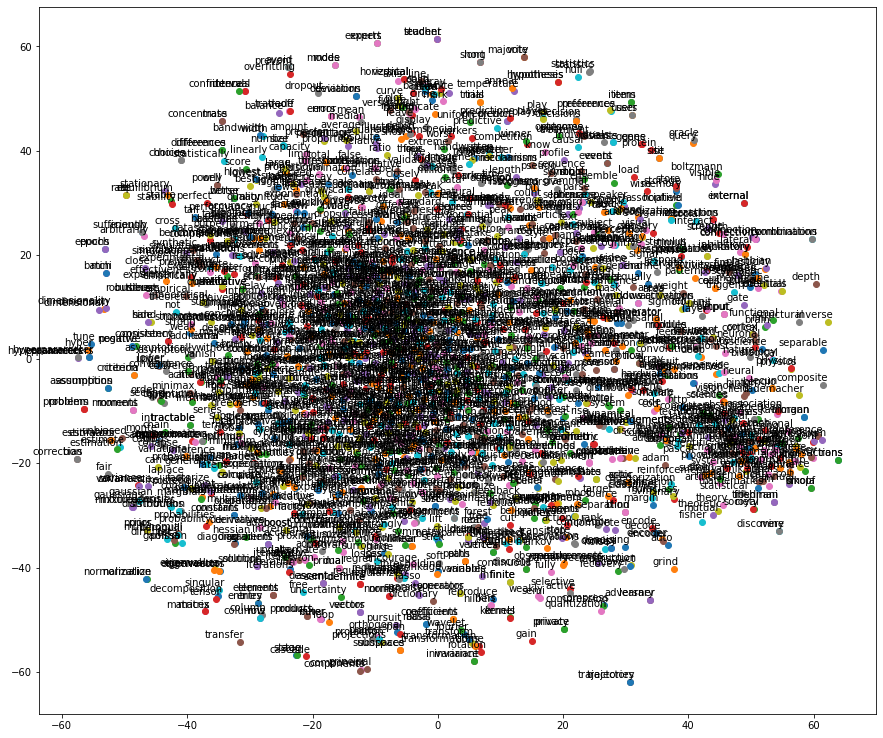

In [25]:
tsne_plot(w2v_model_2)

**Work in progress.**